In [ ]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

import tensorflow as tf

import edward as ed
from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf

ed.set_seed(42)

In [ ]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [ ]:
N, D = X_train.shape

print(N, D)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

In [5]:
H = 5

X = tf.placeholder(tf.float32, [None, D])

def neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

# MODEL
W_0 = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
W_1 = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
W_2 = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))

b_0 = Normal(loc=tf.zeros(H), scale=tf.ones(H))
b_1 = Normal(loc=tf.zeros(H), scale=tf.ones(H))
b_2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

nn = neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)

y  = Bernoulli(logits=nn, dtype=tf.float32)

In [6]:
qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, H])),
              scale=tf.Variable(tf.random_normal([D, H])))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([H, H])),
              scale=tf.Variable(tf.random_normal([H, H])))
qW_2 = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
              scale=tf.Variable(tf.random_normal([H, 1])))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([H])),
              scale=tf.Variable(tf.random_normal([H])))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([H])),
              scale=tf.Variable(tf.random_normal([H])))
qb_2 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.Variable(tf.random_normal([1])))

In [ ]:
# sess = ed.get_session()
# tf.global_variables_initializer().run()

In [9]:
# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(0)
mus = tf.stack(
    [neural_network(
        X_test.astype('float32'), 
        qW_0.sample(), 
        qW_1.sample(),
        qW_2.sample(),        
        qb_0.sample(), 
        qb_1.sample(),
        qb_2.sample(),
    )
    for _ in range(10)])

In [ ]:
# outputs = mus.eval()
# pred = outputs.mean(axis=0) > 0.5

# fig, ax = plt.subplots()
# ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
# ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
# sns.despine()
# ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [10]:
inference = ed.KLqp({
        W_0: qW_0, b_0: qb_0,
        W_1: qW_1, b_1: qb_1,
        W_2: qW_2, b_2: qb_2
    }, 
    data={
        X: X_train,
        y: Y_train
    }
)

In [11]:
inference.run(n_iter=5000, n_samples=1)

# inference.initialize(logdir='.')

# inference.n_iter = 1000

# tf.global_variables_initializer().run()

# for _ in range(inference.n_iter):
#     info_dict = inference.update()
#     inference.print_progress(info_dict)

# inference.finalize()

5000/5000 [100%] ██████████████████████████████ Elapsed: 24s | Loss: 123.090


In [12]:
outputs = mus.eval()
pred = outputs.mean(axis=0) > 0.5
uncer = outputs.std(axis=0)

# # pred = outputs[2,:] > 0.5

# # fig, ax = plt.subplots()
# # ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
# # ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
# # sns.despine()
# # ax.set(title='Actual labels in testing set', xlabel='X', ylabel='Y');

# fig, ax = plt.subplots()
# ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
# ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
# sns.despine()
# ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [13]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
Xx, Yy = grid

back_mus = tf.stack(
    [neural_network(
        grid_2d.astype('float32'), 
        qW_0.sample(), 
        qW_1.sample(),
        qW_2.sample(),        
        qb_0.sample(), 
        qb_1.sample(),
        qb_2.sample(),
    )
    for _ in range(100)])

outputs = mus.eval()
pred = outputs.mean(axis=0) > 0.5

back_outputs = back_mus.eval()

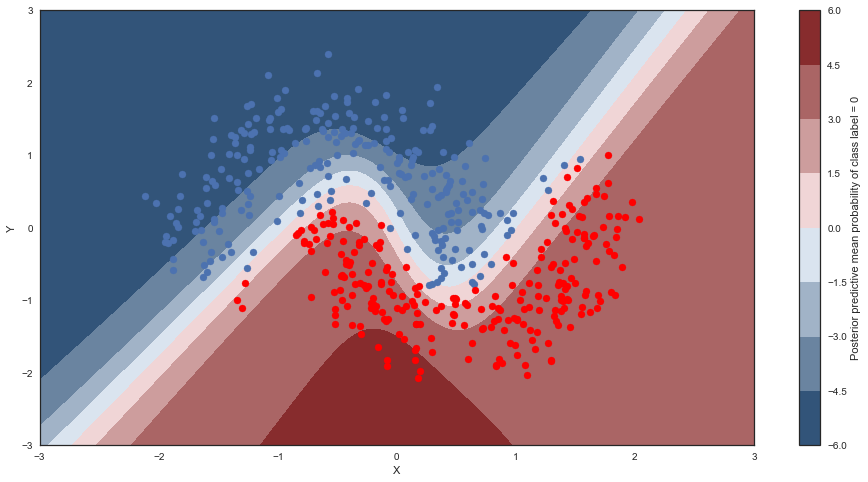

In [14]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 8))
contour = ax.contourf(Xx, Yy, back_outputs.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

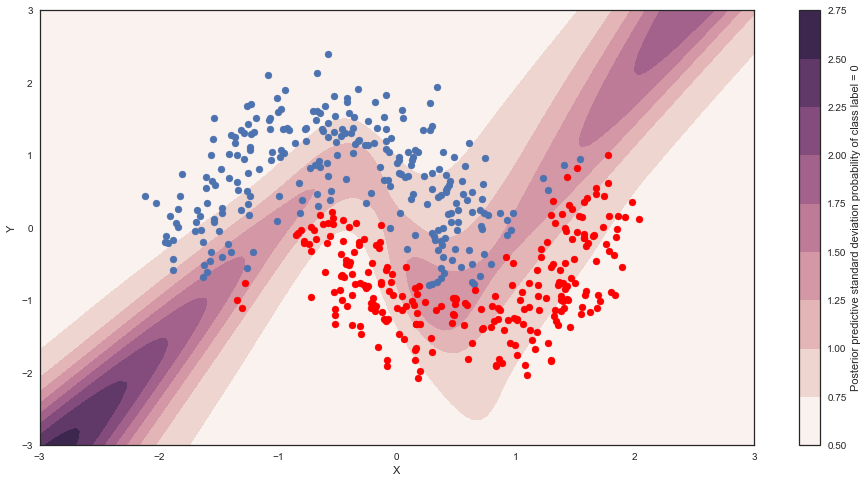

In [15]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 8))
contour = ax.contourf(Xx, Yy, back_outputs.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive standard deviation probability of class label = 0');

In [16]:
X

<tf.Tensor 'Placeholder:0' shape=(?, 2) dtype=float32>

In [17]:
x_post = ed.copy(X, {
    W_0: qW_0, b_0: qb_0,
    W_1: qW_1, b_1: qb_1,
    W_2: qW_2, b_2: qb_2
})

y_post = ed.copy(y, {
    W_0: qW_0, b_0: qb_0,
    W_1: qW_1, b_1: qb_1,
    W_2: qW_2, b_2: qb_2
})

In [18]:
print("Accuracy error on test data:")
print(ed.evaluate('binary_accuracy', data={X: X_test, y_post: Y_test}))

Accuracy error on test data:
0.944


In [19]:
y_post.sample().eval({X: X_test})

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
        1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,
        0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0

In [20]:
def reduce_mean(data, lvars):
#     print(data[X])
#     print(data[y])
#     print(data[x_post])
#     print(data[y_post])
#     print(data.keys())
#     print(lvars.keys())
#     print(data[y_post])
#     print(data[y_post].shape)
    return tf.convert_to_tensor(data[y_post])


a, b = ed.ppc(
    reduce_mean, 
    data={y_post: Y_train, X: X_train}, 
    latent_vars={
        W_0: qW_0, b_0: qb_0,
        W_1: qW_1, b_1: qb_1,
        W_2: qW_2, b_2: qb_2
    },
    n_samples=100
)

print(a.shape, b.shape)
a

(100, 500) (100, 500)


array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  1.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)

(array([ 231.,   14.,    8.,    4.,    5.,    3.,    8.,    7.,   21.,  199.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

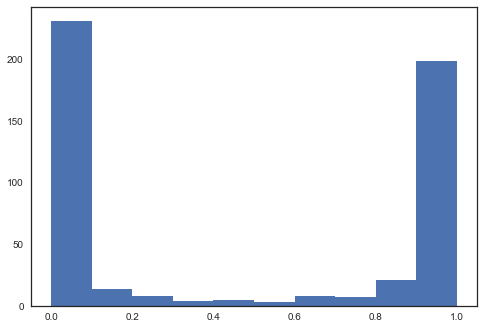

In [22]:
plt.hist(a.mean(axis=0))

In [23]:
a.mean(axis=0)

array([ 0.98000002,  0.97000003,  0.03      ,  0.02      ,  0.97000003,
        0.04      ,  0.99000001,  0.99000001,  0.99000001,  0.97000003,
        0.02      ,  0.03      ,  0.02      ,  0.03      ,  0.02      ,
        0.97000003,  0.95999998,  0.01      ,  0.98000002,  0.        ,
        0.        ,  0.1       ,  0.02      ,  0.94      ,  0.03      ,
        0.83999997,  0.94      ,  0.69999999,  0.98000002,  0.01      ,
        0.99000001,  0.02      ,  0.98000002,  0.99000001,  0.03      ,
        0.04      ,  0.97000003,  0.        ,  1.        ,  0.91000003,
        0.98000002,  0.95999998,  0.88999999,  0.        ,  0.01      ,
        1.        ,  0.03      ,  0.02      ,  0.02      ,  0.01      ,
        0.89999998,  0.02      ,  0.        ,  0.02      ,  0.91000003,
        0.01      ,  0.01      ,  0.        ,  0.99000001,  0.98000002,
        0.99000001,  0.94999999,  0.01      ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.94

In [30]:
a, b = ed.ppc(
    reduce_mean, 
    data={y_post: Y_train, X: grid_2d}, 
    latent_vars={
        W_0: qW_0, b_0: qb_0,
        W_1: qW_1, b_1: qb_1,
        W_2: qW_2, b_2: qb_2
    },
    n_samples=1000
)

print(a.shape, b.shape)
a

(1000, 10000) (1000, 500)


array([[ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [ 1.,  0.,  0., ...,  1.,  1.,  1.]], dtype=float32)

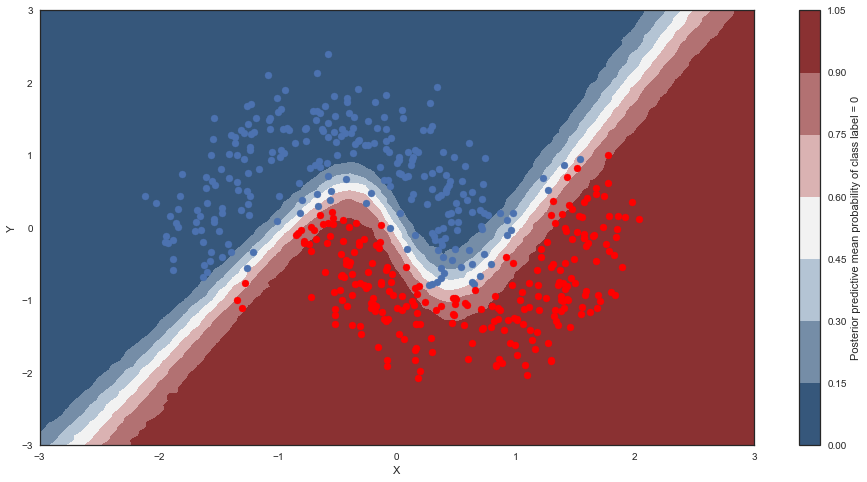

In [31]:
pred = outputs.mean(axis=0) > 0.5

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 8))
contour = ax.contourf(Xx, Yy, a.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

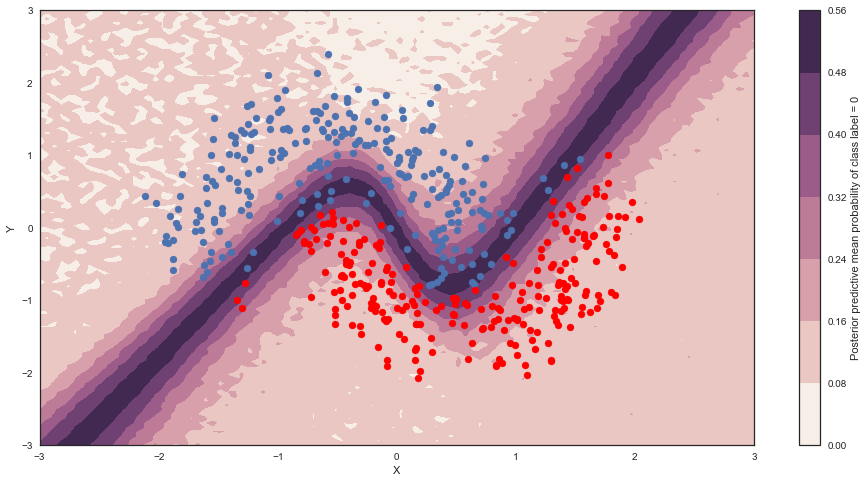

In [32]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 8))
contour = ax.contourf(Xx, Yy, a.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');